#  RAG 파이프라인 구축 및 평가

In [1]:
# 필요한 라이브러리 임포트
import os
import json
import pandas as pd
import re
from typing import List, Any, Optional
from datetime import datetime
from tqdm import tqdm
from pathlib import Path

from langchain_community.document_loaders import (
    DirectoryLoader,
    UnstructuredMarkdownLoader,
)
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

# LangSmith 설정
from langchain_teddynote import logging

logging.langsmith("HUMETRO_LOCAL_RAG_EVAL")  # 프로젝트 이름 설정

LangSmith 추적을 시작합니다.
[프로젝트명]
HUMETRO_LOCAL_RAG_EVAL


## 1. 프로젝트 개요
휴메트로 AI 어시스턴트는 한국 도시철도 역무 지식에 특화된 RAG(Retrieval-Augmented Generation) 시스템입니다. 

프로젝트의 목표는 다음과 같습니다.
  - 도시철도 역무 관련 문서를 효과적으로 색인화하여 검색 가능한 지식베이스 구축
  - 다양한 로컬 LLM 모델을 평가하여 최적의 성능 비교
  - 한국어 도메인에 특화된 RAG 시스템 개발
  - 객관적인 평가 방법론을 통한 모델 성능 측정

이 노트북은 데이터 로드부터 모델 평가까지 전체 RAG 파이프라인 워크플로우를 담고 있습니다.

## 2. 데이터 로드 및 전처리
### 원본 문서

부산교통공사 운영직 교육 자료(공식, 비공식)
  - 야 너두 역무전문가
  - 역무지식 100제
  - 일타 역무
  - 직원 교육 표준자료

### 문서 전처리

  - 한글 문서를 마크다운 형식으로 변환   
  - hwp5html 라이브러리 활용   
  - hwp -> html -> markdown으로 변환

### 문서 로드
  - 아래의 `load_documents` 함수로 문서를 로드하고
  - `split_documents` 함수로 문서를 분할합니다. (800토큰 기준, 오버랩 100)
  - k=4, min_context_length = 4096


In [2]:
def load_documents(doc_dir: str) -> List[Document]:
    """
    특정 디렉토리에서 마크다운 문서를 로드합니다.

    Args:
        doc_dir: 마크다운 문서가 있는 디렉토리 경로

    Returns:
        문서 리스트
    """
    try:
        # 마크다운 로더 생성
        loader = DirectoryLoader(
            doc_dir,
            glob="*.md",  # 현재폴더의 마크다운만 로드
            loader_cls=UnstructuredMarkdownLoader,
            show_progress=True,
            recursive=False,  # 하위 디렉토리는 검색하지 않음
        )

        # 문서 로드
        documents = loader.load()

        print(f"로드된 문서 수: {len(documents)}")

        # 파일 이름을 metadata에 추가
        for doc in documents:
            if "source" in doc.metadata:
                doc.metadata["filename"] = os.path.basename(doc.metadata["source"])

        return documents

    except Exception as e:
        print(f"문서 로드 중 오류 발생: {e}")
        return []


# 문서 로드 실행
doc_dir = Path("./datasets/final_docs")
documents = load_documents(doc_dir)

100%|██████████| 36/36 [00:02<00:00, 12.33it/s]

로드된 문서 수: 36


In [ ]:
def split_documents(
    documents: List[Document],
    chunk_size: int = 800,
    chunk_overlap: int = 100,
    include_filename_in_content: bool = False,
) -> List[Document]:
    """
    문서를 청크로 분할하면서 파일 이름 정보를 유지합니다.

    Args:
        documents: 분할할 문서 리스트
        chunk_size: 각 청크의 크기(토큰 수)
        chunk_overlap: 인접한 청크 간의 겹치는 토큰 수
        include_filename_in_content: 파일 이름을 본문에도 포함할지 여부

    Returns:
        분할된 문서 청크 리스트
    """
    # 파일 이름을 본문에 포함하는 경우, 새 문서 리스트 생성
    if include_filename_in_content:
        preprocessed_docs = []
        for doc in documents:
            filename = doc.metadata.get("filename", "Unknown")
            new_content = f"파일: {filename}\n\n{doc.page_content}"

            # 새 문서 생성 (메타데이터는 유지)
            new_doc = Document(page_content=new_content, metadata=doc.metadata)
            preprocessed_docs.append(new_doc)

        # 처리할 문서를 전처리된 문서로 교체
        documents = preprocessed_docs

    # 토큰 기반 분할기 생성
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ". ", " ", ""],
    )

    # 문서 분할
    splits = text_splitter.split_documents(documents)

    print(f"원본 문서 수: {len(documents)}, 분할 후 청크 수: {len(splits)}")

    # 청크 길이 통계
    lengths = [len(doc.page_content) for doc in splits]
    if lengths:
        print(
            f"청크 길이 - 평균: {sum(lengths) / len(lengths):.1f}, 최소: {min(lengths)}, 최대: {max(lengths)}"
        )

    return splits


# 문서 분할 실행
splits = split_documents(documents)

## 3. 벡터 데이터베이스 구축
  - retrieveral 과정의 semantic search 에 사용되는 벡터 데이터베이스 구축
  - 범용적인 로컬 벡터 데이터베이스인 chroma 사용
  - 임베딩 모델은 OpenAI 의 text-embedding-3-small 사용
  - 로컬에 저장하여 사용

In [ ]:
def create_embeddings(model_name="text-embedding-3-small"):
    """OpenAI 임베딩 모델을 생성합니다."""
    return OpenAIEmbeddings(model=model_name, dimensions=1536)


def create_vectorstore(
    splits, embeddings, persist_dir, collection_name="rag_documents"
):
    """문서 청크를 임베딩하여 Chroma 벡터스토어에 저장합니다."""
    os.makedirs(persist_dir, exist_ok=True)

    if os.path.exists(os.path.join(persist_dir, "chroma.sqlite3")):
        vectorstore = Chroma(
            persist_directory=persist_dir,
            embedding_function=embeddings,
            collection_name=collection_name,
        )

        print(f"기존 벡터스토어 문서 수: {vectorstore._collection.count()}")

        if splits:
            vectorstore.add_documents(splits)
            vectorstore.persist()
            print(
                f"벡터스토어 업데이트 완료. 총 문서 수: {vectorstore._collection.count()}"
            )
    else:
        vectorstore = Chroma.from_documents(
            documents=splits,
            embedding=embeddings,
            persist_directory=persist_dir,
            collection_name=collection_name,
        )
        vectorstore.persist()
        print(f"벡터스토어 생성 완료. 문서 수: {vectorstore._collection.count()}")

    return vectorstore


def load_vectorstore(persist_dir, embeddings, collection_name="rag_documents"):
    """저장된 Chroma 벡터스토어를 로드합니다."""
    if os.path.exists(os.path.join(persist_dir, "chroma.sqlite3")):
        vectorstore = Chroma(
            persist_directory=persist_dir,
            embedding_function=embeddings,
            collection_name=collection_name,
        )
        print(f"벡터스토어 로드 완료. 문서 수: {vectorstore._collection.count()}")
        return vectorstore
    else:
        print(f"벡터스토어를 찾을 수 없습니다: {persist_dir}")
        return None


# 임베딩 및 벡터스토어 생성
embeddings = create_embeddings()
persist_dir = "vectorstore"
vectorstore = create_vectorstore(
    splits=splits, embeddings=embeddings, persist_dir=persist_dir
)

# 벡터스토어 로드 테스트
loaded_vectorstore = load_vectorstore(persist_dir, embeddings)

## 4. 모델 평가를 위한 합성 데이터셋 생성
  - X_AI 의 Grok-3-beta 및 gpt-4o를 데이터 생성의 기반 LLM으로 활용
  - RAG 시스템의 평가에 널리 사용되는 RAGAS 프레임워크를 활용해서 데이터셋 생성
  - 싱글 홉 질문, 멀티 홉 질문을 7:3 비율로 약 500여개 데이터셋 생성

In [ ]:
from ragas.testset import TestsetGenerator
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset.synthesizers.single_hop.specific import (
    SingleHopSpecificQuerySynthesizer,
)
from ragas.testset.synthesizers.multi_hop.specific import (
    MultiHopSpecificQuerySynthesizer,
)
import nest_asyncio

nest_asyncio.apply()


async def generate_qa_dataset(
    splits, output_path="datasets/synthetic_qa_dataset.csv", num_questions=200
):
    """
    RAGAS를 사용하여 합성 QA 데이터셋을 생성합니다.

    Args:
        splits: 내용에서 질문을 생성할 Document 객체 목록
        output_path: CSV 데이터셋을 저장할 경로
        num_questions: 생성할 질문 수

    Returns:
        생성된 데이터셋이 담긴 Pandas DataFrame
    """
    # LLM 및 임베딩 래퍼 초기화
    llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
    embeddings = LangchainEmbeddingsWrapper(
        OpenAIEmbeddings(model="text-embedding-3-small")
    )

    # TestsetGenerator 생성
    generator = TestsetGenerator(llm=llm, embedding_model=embeddings)

    # 질문 유형 분포 설정 (SingleHop 70%, MultiHop 30%)
    distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=llm), 0.7),
        (MultiHopSpecificQuerySynthesizer(llm=llm), 0.3),
    ]

    # 한국어로 질문과 답변 생성하도록 프롬프트 변경
    for query, _ in distribution:
        prompts = await query.adapt_prompts(
            "## 매우 중요: **한국어로만 질문과 답변을 생성**, Question and Answer MUST be in KOREAN",
            llm=llm,
        )
        query.set_prompts(**prompts)

    # 테스트셋 생성
    print(f"총 {num_questions}개의 QA 쌍 생성 중...")
    testset = generator.generate_with_langchain_docs(
        documents=splits,
        testset_size=num_questions,
        query_distribution=distribution,
    )

    # DataFrame으로 변환
    test_df = testset.to_pandas()

    # CSV로 저장
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    test_df.to_csv(output_path, index=False)

    print(f"QA 데이터셋 생성 완료: {len(test_df)}개의 질문-답변 쌍")
    print(f"{output_path}에 저장됨")

    return test_df


import asyncio

test_df = asyncio.run(generate_qa_dataset(splits, num_questions=100))

## 5. 영어 데이터셋 한국어 번역
- 생성된 영어 데이터셋을 한국어로 번역하여 도메인에 특화된 평가 데이터셋을 만듭니다.
- RAGAS 프레임워크의 내부 프롬프트로 인해 생성된 영어로 된 질문을 한국어로 배치 번역
- gpt-4o-mini 활용


## 6. 평가 데이터 생성을 위한 RAG chain 구축

### 6.1 체인의 구성요소
 - params <= 4B (int8 quant VRAM <= 32GB>, FP16 VRAM <= 64GB)   
   Runnable on Single Consumer GPU (RTX 4090 32GB)
 - local models 
    - "hyperclovax-seed-text-instruct-1.5b-hf-i1",
    - "kakaocorp.kanana-nano-2.1b-instruct",
    - "exaone-3.5-2.4b-instruct",
    - "qwen/qwen3-4b:free",
    - "google/gemma-3-4b-it:free"  

 - bigger models  
    - "deepseek/deepseek-chat-v3-0324:free", # 685B, OpenSource
    - "gpt-4o-mini", # Baseline, OpenAI, Proprietary Model, known as 8B
 - retriever
    - chroma vector database
    - OpenAI text-embedding-3-small
    - Naive RAG applied
 - rag chain
    - langchain
    - retriever
    - simple RAG Prompt

### 6.2수행과정
1. 합성 데이터셋의 질문을 retriever에 넣어서 컨텍스트를 받아오고
2. 질문과 컨텍스트를 모델에 넣어 답변을 생성하는 과정
3. 생성한 답변 데이터는 추후 평가에 활용됨
4. gpt-4o-mini 모델은 유사 태스크에 범용적으로 활용되는 모델로서 베이스라인 평가 척도로 활용


### 6.3 체인 구축 및 답변생성 코드

In [ ]:
import json
import os
import re
import subprocess
from typing import Any

import pandas as pd
from langchain.vectorstores import Chroma
from langchain_community.llms import Ollama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_teddynote import logging
from tqdm import tqdm

logging.langsmith("HUMETRO_EVAL_TEST")


def create_embeddings(model_name: str = "text-embedding-3-small") -> OpenAIEmbeddings:
    return OpenAIEmbeddings(model=model_name, dimensions=1536)


def load_vectorstore(persist_directory: str, embeddings: Any) -> Chroma:
    vectorstore = Chroma(
        persist_directory=persist_directory,
        embedding_function=embeddings,
        collection_name="rag_documents",
    )
    print(f"벡터스토어 로드 완료. 문서 수: {vectorstore._collection.count()}")
    return vectorstore


def create_retriever(vectorstore: Chroma, k: int = 4) -> Any:
    return vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": k})


def create_llm(model_signature: str, temperature: float = 0.1) -> Any:
    OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1"
    local_models = [
        "exaone-3.5-2.4b-instruct",
        "kakaocorp.kanana-nano-2.1b-instruct",
        "hyperclovax-seed-text-instruct-1.5b-hf-i1",
    ]
    open_router_models = [
        "qwen/qwen3-4b:free",
        "google/gemma-3-4b-it:free",
        "deepseek/deepseek-chat-v3-0324:free",
    ]
    if "gpt" in model_signature:
        return ChatOpenAI(model=model_signature, temperature=temperature)
    if model_signature in local_models:
        try:
            subprocess.run(["lms", "unload", "-a"])
            print("모든 lms 언로드 완료")
            subprocess.run(["lms", "load", model_signature])
            print(f"lms 모델 {model_signature} 로드 완료")
            return ChatOpenAI(
                base_url="http://localhost:1234/v1", model=model_signature
            )
        except Exception as e:
            print(f"lms 명령 실행 중 오류 발생: {e}")
            print("lms가 설치되어 있고 실행 중인지 확인하세요.")
    if model_signature in open_router_models:
        llm = ChatOpenAI(
            openai_api_key=os.getenv("OPENROUTER_API_KEY"),
            openai_api_base=OPENROUTER_BASE_URL,
            model_name=model_signature,
            temperature=temperature,
        )
        return llm
    return None


# 5. RAG 체인 생성 함수
def create_rag_chain(llm: Any, retriever: Any) -> Any:
    # 한국의 역무환경을 고려한 RAG 프롬프트 템플릿
    template = """
당신은 한국의 도시철도 역무 지식 도우미입니다.
주어진 질문에 대해 제공된 문맥 정보를 기반으로 정확하고 도움이 되는 답변을 제공하세요.
문맥에 없는 내용은 답변하지 마세요. 모르는 경우 솔직히 모른다고 말하세요.

문맥 정보:
{context}

질문: {question}

답변:
"""

    prompt = ChatPromptTemplate.from_template(template)

    def format_docs(docs):
        return "\n\n".join([doc.page_content for doc in docs])

    # LCEL을 사용한 RAG 체인 정의
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    return rag_chain


def sanitize_filename(filename):
    filename.replace(".json", "")
    return re.sub(r"[^a-zA-Z0-9_.]", "_", filename)[:30] + ".json"


if __name__ == "__main__":
    target_models = [
        "qwen/qwen3-4b:free",
        "google/gemma-3-4b-it:free",
        "deepseek/deepseek-chat-v3-0324:free",
        "hyperclovax-seed-text-instruct-1.5b-hf-i1",
        "kakaocorp.kanana-nano-2.1b-instruct",
        "exaone-3.5-2.4b-instruct",
        "gpt-4o-mini",
    ]
    embeddings = create_embeddings()
    vectorstore = load_vectorstore(
        persist_directory="vectorstore", embeddings=embeddings
    )
    if len(vectorstore.similarity_search("서울역 주변 명소")) == 0:
        raise ValueError("vectorstore is empty")
    if len(vectorstore.get()["ids"]) == 0:
        raise ValueError("vectorstore is empty")

    # 질문 데이터 불러오기
    question_data = pd.read_csv("./dataset_200.csv")
    base_questions = list(question_data["user_input"])
    print(base_questions[:10])

    for model_signature in target_models:
        try:
            print(f"Loading {model_signature}...")
            llm = create_llm(model_signature)
            retriever = create_retriever(vectorstore)
            rag_chain = create_rag_chain(llm, retriever)
            filename = sanitize_filename(f"result_{model_signature}.json")
            try:
                with open(filename, "r") as f:
                    result_list = json.load(f)
            except FileNotFoundError:
                result_list = []

            # 이미 처리된 질문 제외
            processed_question = [i["question"] for i in result_list]
            target_questions = [
                i for i in base_questions if i not in processed_question
            ]

            for question in tqdm(
                target_questions, desc=f"Evaluating {model_signature}"
            ):
                try:
                    result = rag_chain.invoke(question)
                    result_list.append({"question": question, "answer": result})
                    if len(result_list) % 10 == 0:  # 10개마다 저장하기
                        print(f"checkpoint, saved {len(result_list)}")
                    with open(filename, "w") as f:
                        json.dump(result_list, f, ensure_ascii=False)
                except Exception as e:
                    print(
                        f"Error: while generating {model_signature} single question {question}: {e}"
                    )
                    continue
            with open(filename, "w") as f:  # 최종 결과 저장하기
                json.dump(result_list, f, ensure_ascii=False)
        except Exception as e:
            print(f"Error: while generating {model_signature}: {e}")
            continue


### 6.4 답변 생성 결과
langsmith 플랫폼을 활용하여 모니터링

https://smith.langchain.com/o/06d0a329-b301-5d27-b5a2-94923e9bb6c0/projects

## 7. RAGAS의 기본 평가 메트릭을 적용한 평가 결과

### 7.1 생성 데이터 후처리

In [ ]:
from langchain_teddynote import logging

logging.langsmith("HUMETRO_EVAL_TEST")


source_df = pd.read_csv(dataset_dir / "ragas_200_with_model_answers.csv")
eval_datasets = {}

for f in qa_data_files:
    dataset = []
    model_name = f.name.replace("result_", "").replace(".json", "")
    print("Create Eval Dataset for ", model_name)
    success_count = 0
    error_list = set()

    for item in source_df.to_dict("records"):
        debug_var = item["reference_outputs"]
        dataset.append(
            {
                "user_input": item["user_input"],
                "retrieved_contexts": [item["reference_outputs"]],
                "response": item[model_name],
                "reference": item["reference"],
            }
        )
    eval_datasets[model_name] = dataset

### 7.2 평가를 위한 LLM 정의
 - gpt-4.1
   - API 코스트 이슈
   - 7개 모델 200개 질문, 2개 메트릭, 메트릭당 4회 호출 (11,000회)
 - grok-3-beta
    - 무료 크레딧 보유  
    - 크레딧 사용량  
    <img src="/Users/sdh/Dev/projects/humetro-ai-assistant/grok_usage_cropped.png" width="500">

In [ ]:
## 7.2
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas import EvaluationDataset

from langchain_openai import ChatOpenAI
from langchain_xai import ChatXAI
from langchain_openai import OpenAIEmbeddings

llm = ChatOpenAI(model="gpt-4.1-2025-04-14")
llm = ChatXAI(model="grok-3-beta")
embeddings = OpenAIEmbeddings()
# testing llm response
response = llm.invoke("hello").content
print(response)


### 7.3 RAGAS의 기본 메트릭을 활용한 평가 수행
#### 메트릭 소개
0. Heuristic Metrics
  - BLUE
  - ROUGE
2. FactualCorrectness
  -  응답이 **레퍼런스 응답**과 얼마나 사실적으로 일치하는지를 측정.
  -  레퍼런스 응답은 합성자료 생성시 만든 **정답**으로서의 답변을 의미
3. Faithfulness
  - 응답이 **컨텍스트로 주어진 문서**와 얼마나 일치하는지를 측정.
  - 응답 생성시 Retrieval 과정에서 사용된 컨텍스트를 의미
  - 질문과 코사인 유사도를 활용한 의미적으로 가장 가까운 문서들의 집합

In [ ]:
evaluator_llm = LangchainLLMWrapper(llm)
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness

eval_results = {}
# for key, dataset in eval_datasets.items():
dataset = eval_datasets["qwen_qwen3_4b_free"]
key = "qwen_qwen3_4b_free"
try:
    print(f"Evaluating {key}...")
    evaluation_dataset = EvaluationDataset.from_list(dataset)
    result = evaluate(
        dataset=evaluation_dataset,
        metrics=[Faithfulness(), FactualCorrectness()],
        llm=evaluator_llm,
    )
    print(key, "data_size", len(evaluation_dataset), " -> ", result)
    eval_results[key] = result
except Exception as e:
    print(f"Error evaluating {key}: {e}")
    eval_results[key] = None

with open("eval_results_200_grok.json", "w") as f:
    json.dump(eval_results, f)

### 7.4 메트릭 평가 기준
1. Thresholds
- Deep Eval Threshold (https://www.deepeval.com/docs/metrics-ragas)
  -  DeepEval에서의 임계값: DeepEval이라는 프레임워크에서는 RagasMetric을 사용할 때 임계값(threshold)을 0.5로 설정.
  -  "합격/불합격" 테스트 케이스를 결정하는 부동 소수점 값을 나타냅니다.
- Evaluation of RAG Metrics for Question Answering in the Telecom Domain(https://arxiv.org/html/2407.12873v1)
  -  텔레콤 도메인 연구에서 제안한 것처럼, 사실적 정확성과 충실성을 함께 사용하면 응답의 품질을 더 잘 평가할 수 있습니다.
  -   두 메트릭 모두에서 적어도 0.7 이상의 점수를 요구
2. Goals
  - baseline score : 0.5 on both metrics
  - target score : 0.7 on both metrics

In [2]:
{
    "hyperclovax_seed_text_1.5b": {
        "faithfulness": 0.3661,
        "factual_correctness(mode=f1)": 0.302,
    },
    "kakaocorp.kanana_nano_2.1b": {
        "faithfulness": 0.4089,
        "factual_correctness(mode=f1)": 0.3714,
    },
    "exaone_3.5_2.4b_instruc": {
        "faithfulness": 0.4023,
        "factual_correctness(mode=f1)": 0.371,
    },
    "google_gemma_3_4b_it_fr": {
        "faithfulness": 0.5984,
        "factual_correctness(mode=f1)": 0.4223,
    },
    "qwen_qwen3_4b_free": {
        "faithfulness": 0.509,
        "factual_correctness(mode=f1)": 0.4147,
    },
    "deepseek_deepseek_chat_": {
        "faithfulness": 0.5682,
        "factual_correctness(mode=f1)": 0.44,
    },
    "gpt_4o_mini": {"faithfulness": 0.6388, "factual_correctness(mode=f1)": 0.4881},
}


{'hyperclovax_seed_text_1.5b': {'faithfulness': 0.3661,
  'factual_correctness(mode=f1)': 0.302},
 'kakaocorp.kanana_nano_2.1b': {'faithfulness': 0.4089,
  'factual_correctness(mode=f1)': 0.3714},
 'exaone_3.5_2.4b_instruc': {'faithfulness': 0.4023,
  'factual_correctness(mode=f1)': 0.371},
 'google_gemma_3_4b_it_fr': {'faithfulness': 0.5984,
  'factual_correctness(mode=f1)': 0.4223},
 'qwen_qwen3_4b_free': {'faithfulness': 0.509,
  'factual_correctness(mode=f1)': 0.4147},
 'deepseek_deepseek_chat_': {'faithfulness': 0.5682,
  'factual_correctness(mode=f1)': 0.44},
 'gpt_4o_mini': {'faithfulness': 0.6388,
  'factual_correctness(mode=f1)': 0.4881}}

### 7.5 메트릭 시각화

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import warnings

warnings.filterwarnings("ignore")

rc("font", family="AppleGothic")
# 마이너스 부호 깨짐 방지
mpl.rcParams["axes.unicode_minus"] = False

In [9]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
import platform
import os


# M1 맥용 한글 폰트 설정 코드
def set_korean_font_for_mac():
    # 시스템에 설치된 폰트 목록 확인 (문제 해결용)
    korean_fonts = [
        f.name
        for f in fm.fontManager.ttflist
        if any(
            char in f.name
            for char in ["Gothic", "Myungjo", "돋움", "고딕", "명조", "Apple", "Nanum"]
        )
    ]

    # 1. AppleGothic 폰트 설정 시도 (macOS 기본)
    try:
        plt.rc("font", family="AppleGothic")
        # 테스트
        fig, ax = plt.subplots(figsize=(3, 1))
        ax.text(0.5, 0.5, "한글 테스트", ha="center", va="center", fontsize=15)
        plt.close(fig)
        return
    except Exception as e:
        pass

    # 2. 대안: 맥에서 사용 가능한 다른 한글 폰트 시도
    mac_fonts = [
        "AppleGothic",
        "AppleMyungjo",
        "AppleSDGothicNeo",
        "NanumGothic",
        "NanumMyeongjo",
        "NanumBarunGothic",
        "NanumSquare",
        "KoPubDotum",
        "나눔고딕",
        "맑은 고딕",
    ]

    for font_name in mac_fonts:
        try:
            plt.rc("font", family=font_name)
            # 테스트
            fig, ax = plt.subplots(figsize=(3, 1))
            ax.text(0.5, 0.5, "한글 테스트", ha="center", va="center", fontsize=15)
            plt.close(fig)
            return
        except Exception:
            continue

    # 3. 폰트 경로 직접 지정 시도
    try:
        # 나눔고딕 폰트가 설치되어 있다면
        nanum_path = os.path.expanduser("~/Library/Fonts/NanumGothic.ttf")
        if os.path.exists(nanum_path):
            font_prop = fm.FontProperties(fname=nanum_path)
            plt.rcParams["font.family"] = font_prop.get_name()
            print("\n✓ 나눔고딕 폰트 파일 직접 지정 성공")
            return
    except Exception as e:
        print(f"\n✗ 폰트 파일 직접 지정 실패: {e}")

    # 4. 마지막 방법: TTF 폰트 등록
    # fonts_path = '/System/Library/Fonts'  # 시스템 폰트 경로
    fonts_path = "/Library/Fonts"  # 사용자 폰트 경로
    korean_fonts = []

    for font_file in os.listdir(fonts_path):
        if font_file.endswith(".ttf") or font_file.endswith(".otf"):
            try:
                font_path = os.path.join(fonts_path, font_file)
                prop = fm.FontProperties(fname=font_path)
                name = prop.get_name()
                if any(
                    char in name
                    for char in ["Gothic", "Myungjo", "돋움", "고딕", "명조", "Apple"]
                ):
                    korean_fonts.append((name, font_path))
            except:
                pass

    if korean_fonts:
        name, path = korean_fonts[0]
        font_prop = fm.FontProperties(fname=path)
        plt.rcParams["font.family"] = font_prop.get_name()
        print(f"\n✓ 시스템에서 발견한 한글 폰트({name}) 설정 성공")
    else:
        print("\n✗ 사용 가능한 한글 폰트를 찾을 수 없습니다.")


# 한글 폰트 설정 적용
set_korean_font_for_mac()

# 마이너스 부호 깨짐 방지
mpl.rcParams["axes.unicode_minus"] = False


In [11]:
import matplotlib.font_manager

# 폰트 캐시를 다시 빌드합니다.
# 이 코드를 실행한 후에는 커널(Kernel)을 재시작해야 변경 사항이 적용될 수 있습니다.
matplotlib.font_manager._load_fontmanager(try_read_cache=False)

Matplotlib is building the font cache; this may take a moment.


              display_name  params_billion  faithfulness  factual_correctness  \
0               Gpt (8.0B)             8.0        0.6388               0.4881   
1            Google (4.0B)             4.0        0.5984               0.4223   
2  DeepseekV3 (685.0B) MoE           685.0        0.5682               0.4400   
3              Qwen (4.0B)             4.0        0.5090               0.4147   
4  Kakaocorp.kanana (2.1B)             2.1        0.4089               0.3714   
5            Exaone (2.4B)             2.4        0.4023               0.3710   
6       Hyperclovax (1.5B)             1.5        0.3661               0.3020   

   combined_score  faith_to_fact_ratio  
0         0.56345             1.308748  
1         0.51035             1.417002  
2         0.50410             1.291364  
3         0.46185             1.227393  
4         0.39015             1.100969  
5         0.38665             1.084367  
6         0.33405             1.212252  


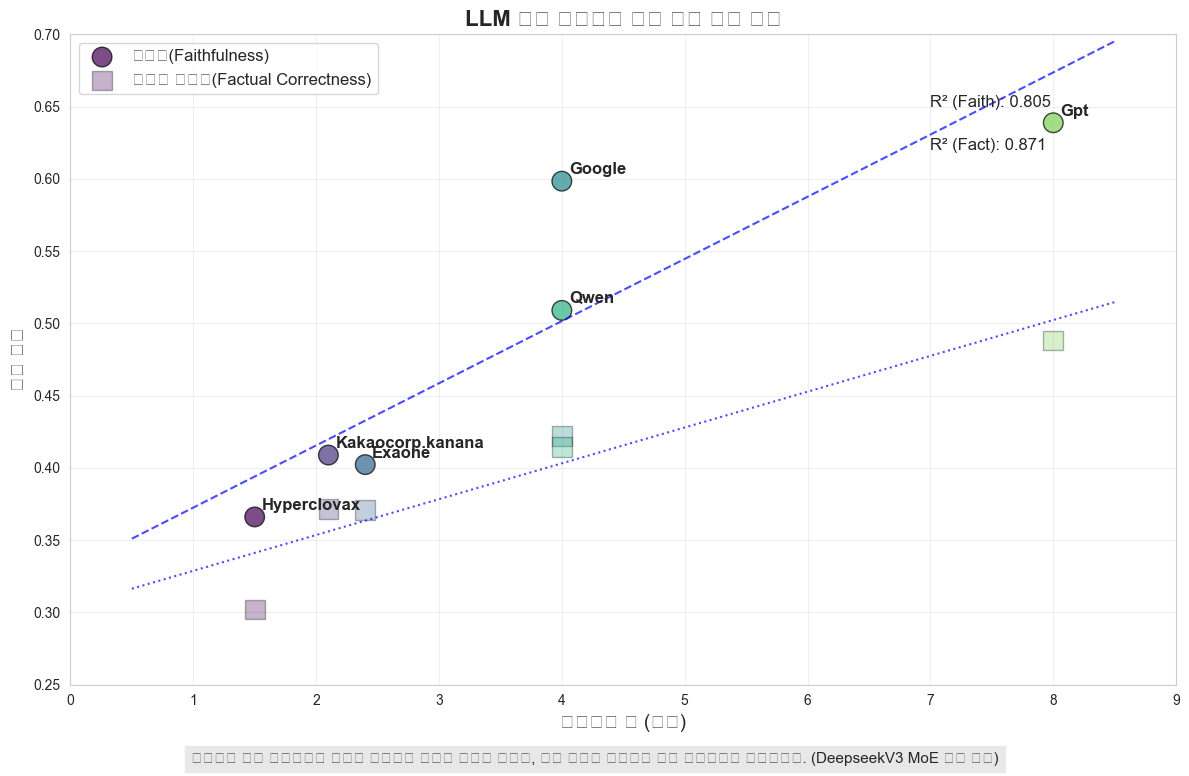

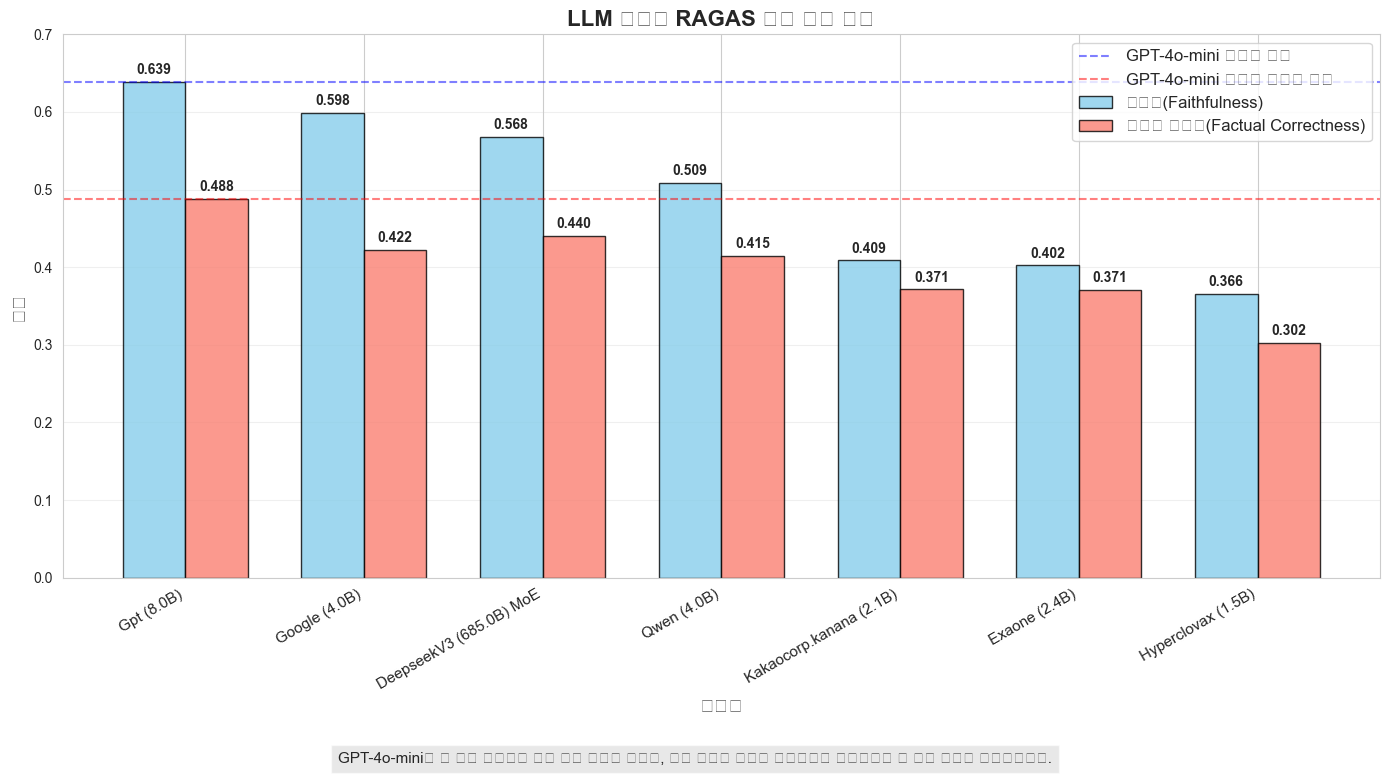

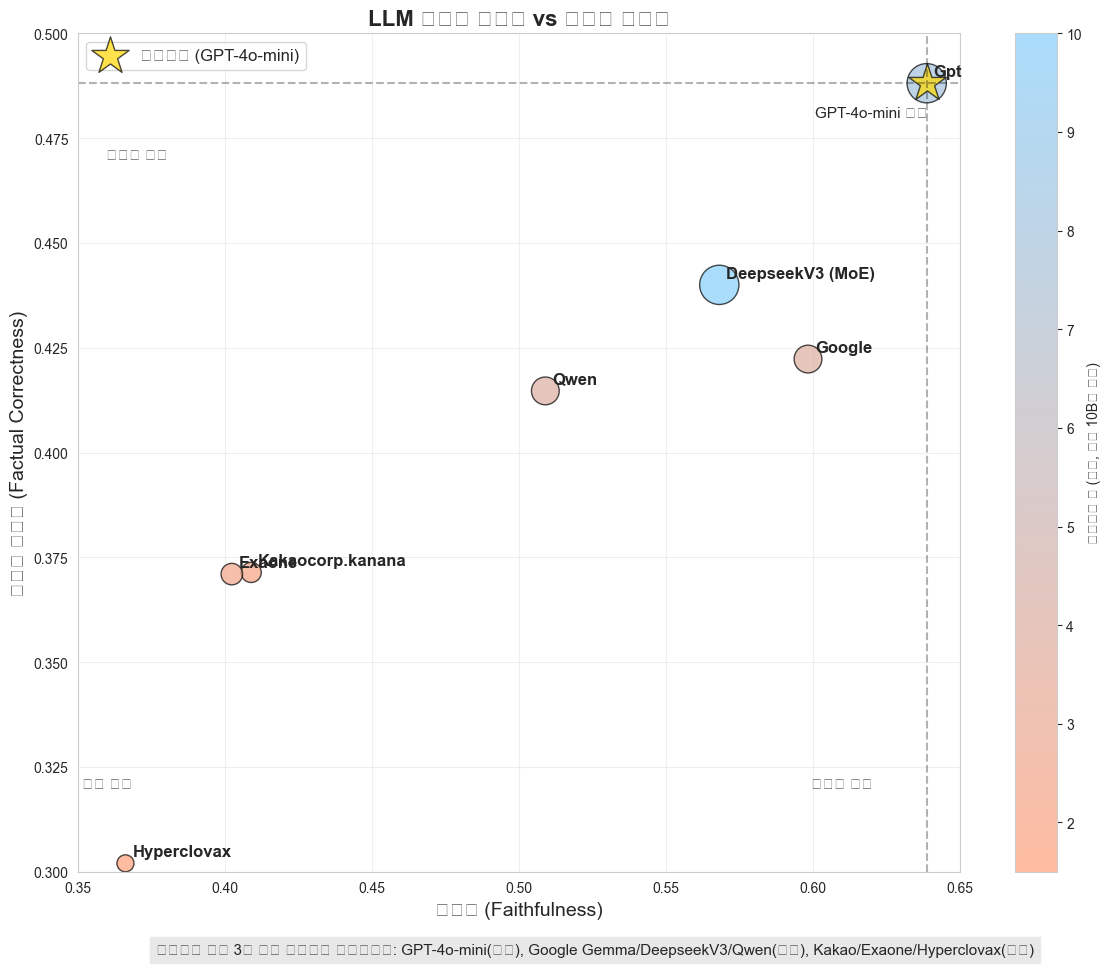

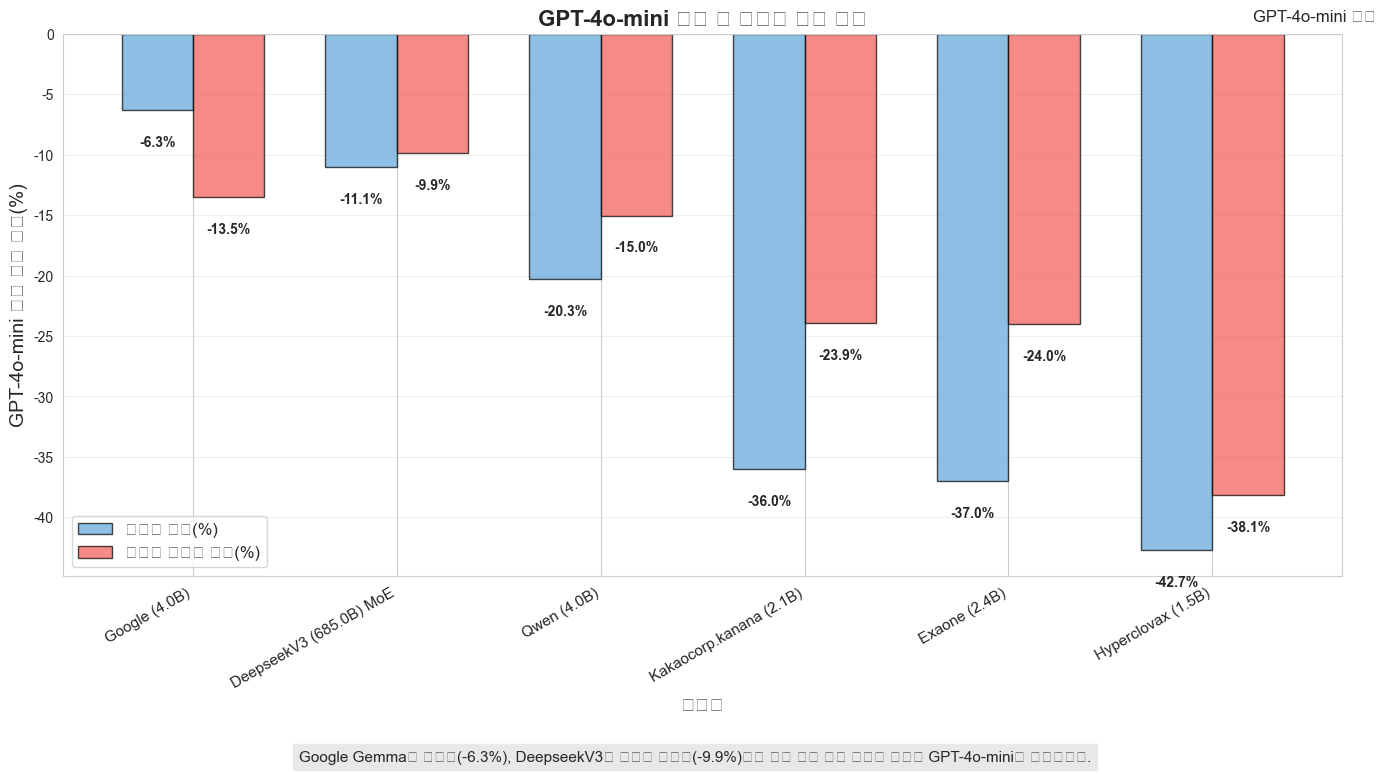

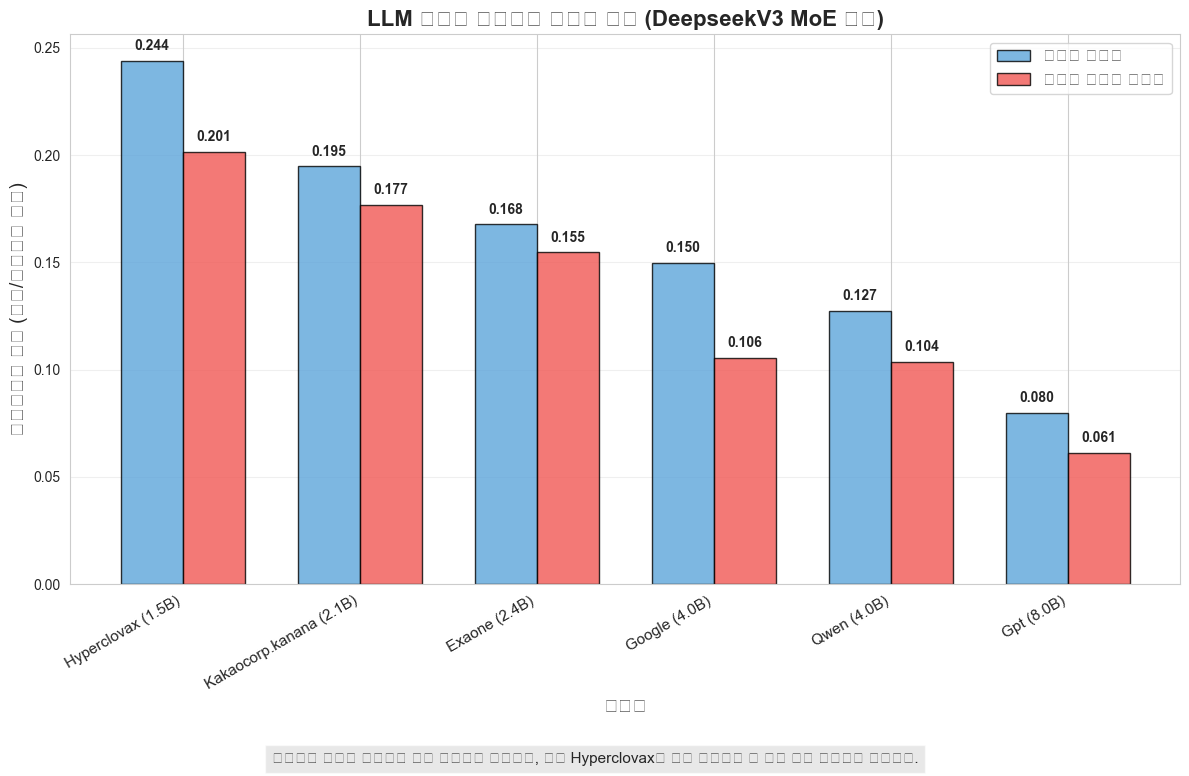

시각화가 완료되었습니다. 파라미터 수와 성능 지표의 관계를 다양한 관점에서 분석했습니다.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap  # 이 줄 추가
from scipy.stats import linregress  # 이 줄 추가

# ------------------- 한글 폰트 설정 시작 -------------------
# 운영체제에 따른 폰트 설정
import platform

if platform.system() == "Windows":
    plt.rc("font", family="Malgun Gothic")  # 맑은 고딕으로 설정
elif platform.system() == "Darwin":  # Mac OS
    plt.rc("font", family="AppleGothic")  # 애플고딕으로 설정
else:  # Linux 등 기타 OS
    # 나눔고딕이 설치되어 있다면 아래 주석 해제
    # plt.rc('font', family='NanumGothic')
    # 또는 다른 설치된 한글 폰트 이름을 사용하세요.
    # 아래는 시스템에 설치된 폰트를 찾는 예시 코드입니다.
    # import matplotlib.font_manager as fm
    # font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # 예시 경로
    # font_name = fm.FontProperties(fname=font_path, size=10).get_name()
    # plt.rc('font', family=font_name)
    # 만약 위 방법이 어렵다면, 사용 가능한 폰트 목록을 확인하고 설정하세요.
    # print([f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name]) # 예시: 나눔 폰트 검색
    # 기본값으로 두거나, 다른 사용 가능한 폰트를 명시해야 할 수 있습니다.
    # 예: plt.rc('font', family='DejaVu Sans') # 기본 폰트 중 하나 (한글 지원 미흡할 수 있음)
    pass  # 적절한 폰트 설정을 추가해주세요.

plt.rc("axes", unicode_minus=False)  # 마이너스 부호 깨짐 방지
# 데이터 준비 - 모델명에서 파라미터 수 추출
data = {
    "model_name": [
        "hyperclovax_seed_text_1.5b",
        "kakaocorp.kanana_nano_2.1b",
        "exaone_3.5_2.4b_instruc",
        "google_gemma_3_4b_it_fr",
        "qwen_qwen3_4b_free",
        "deepseek_deepseek_chat_",
        "gpt_4o_mini",
    ],
    "params_billion": [
        1.5,
        2.1,
        2.4,
        4.0,
        4.0,
        685.0,
        8.0,
    ],  # deepseek은 685B MoE 모델, gpt_4o_mini는 추정치
    "faithfulness": [0.3661, 0.4089, 0.4023, 0.5984, 0.509, 0.5682, 0.6388],
    "factual_correctness": [0.302, 0.3714, 0.371, 0.4223, 0.4147, 0.44, 0.4881],
}

df = pd.DataFrame(data)

# MoE 모델 표시 추가
df["moe"] = df["model_name"].apply(lambda x: "MoE" if "deepseek" in x else "")

# 종합 성능 추가
df["combined_score"] = (df["faithfulness"] + df["factual_correctness"]) / 2

# 기준점(gpt_4o_mini)과의 차이 계산
benchmark_faith = df.loc[df["model_name"] == "gpt_4o_mini", "faithfulness"].values[0]
benchmark_fact = df.loc[
    df["model_name"] == "gpt_4o_mini", "factual_correctness"
].values[0]

df["faith_diff"] = (df["faithfulness"] - benchmark_faith) / benchmark_faith * 100
df["fact_diff"] = (df["factual_correctness"] - benchmark_fact) / benchmark_fact * 100

# 비율 계산
df["faith_to_fact_ratio"] = df["faithfulness"] / df["factual_correctness"]

# 모델명 간소화 및 표시 이름 설정
df["short_name"] = df["model_name"].apply(lambda x: x.split("_")[0].capitalize())
df.loc[df["short_name"] == "Deepseek", "short_name"] = "DeepseekV3"
df["display_name"] = df.apply(
    lambda x: f"{x['short_name']} ({x['params_billion']}B){' ' + x['moe'] if x['moe'] else ''}",
    axis=1,
)

# 성능 순위로 정렬
df_sorted = df.sort_values("combined_score", ascending=False).reset_index(drop=True)

# 출력 테스트
print(
    df_sorted[
        [
            "display_name",
            "params_billion",
            "faithfulness",
            "factual_correctness",
            "combined_score",
            "faith_to_fact_ratio",
        ]
    ]
)

# 1. 파라미터 수 vs 성능 산점도 (MoE 모델 제외)
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# DeepseekV3 제외하고 그래프 그리기 (파라미터 크기 차이가 너무 커서)
df_no_moe = df[df["moe"] == ""]

# 일관된 컬러맵 사용
colors = plt.cm.viridis(np.linspace(0, 0.8, len(df_no_moe)))

plt.scatter(
    df_no_moe["params_billion"],
    df_no_moe["faithfulness"],
    s=200,
    c=[colors[i] for i in range(len(df_no_moe))],
    alpha=0.7,
    edgecolor="black",
    label="충실도(Faithfulness)",
)
plt.scatter(
    df_no_moe["params_billion"],
    df_no_moe["factual_correctness"],
    s=200,
    c=[colors[i] for i in range(len(df_no_moe))],
    alpha=0.3,
    edgecolor="black",
    marker="s",
    label="사실적 정확성(Factual Correctness)",
)

# 모델명 라벨 추가
for i, row in df_no_moe.iterrows():
    plt.annotate(
        row["short_name"],
        (row["params_billion"], row["faithfulness"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=12,
        fontweight="bold",
    )

plt.title("LLM 모델 파라미터 수와 성능 지표 관계", fontsize=16, fontweight="bold")
plt.xlabel("파라미터 수 (십억)", fontsize=14)
plt.ylabel("성능 점수", fontsize=14)
plt.xlim(0, 9)
plt.ylim(0.25, 0.7)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# 추세선 추가
from scipy.stats import linregress

slope_faith, intercept_faith, r_faith, p_faith, std_err_faith = linregress(
    df_no_moe["params_billion"], df_no_moe["faithfulness"]
)
slope_fact, intercept_fact, r_fact, p_fact, std_err_fact = linregress(
    df_no_moe["params_billion"], df_no_moe["factual_correctness"]
)

x_line = np.linspace(0.5, 8.5, 100)
plt.plot(x_line, intercept_faith + slope_faith * x_line, "b--", alpha=0.7)
plt.plot(x_line, intercept_fact + slope_fact * x_line, "b:", alpha=0.7)

# R² 값 추가
plt.text(7, 0.65, f"R² (Faith): {r_faith**2:.3f}", fontsize=12)
plt.text(7, 0.62, f"R² (Fact): {r_fact**2:.3f}", fontsize=12)

# 그래프 의미 설명 추가
plt.figtext(
    0.5,
    0.01,
    "파라미터 수가 증가할수록 성능이 향상되는 명확한 추세를 보이며, 특히 충실도 지표에서 강한 상관관계가 나타납니다. (DeepseekV3 MoE 모델 제외)",
    ha="center",
    fontsize=11,
    bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5},
)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# 2. 모델별 성능 지표 비교 (막대 그래프)
plt.figure(figsize=(14, 8))

x = np.arange(len(df_sorted))
width = 0.35

plt.bar(
    x - width / 2,
    df_sorted["faithfulness"],
    width,
    color="skyblue",
    edgecolor="black",
    alpha=0.8,
    label="충실도(Faithfulness)",
)
plt.bar(
    x + width / 2,
    df_sorted["factual_correctness"],
    width,
    color="salmon",
    edgecolor="black",
    alpha=0.8,
    label="사실적 정확성(Factual Correctness)",
)

for i, v in enumerate(df_sorted["faithfulness"]):
    plt.text(
        i - width / 2, v + 0.01, f"{v:.3f}", ha="center", fontsize=10, fontweight="bold"
    )

for i, v in enumerate(df_sorted["factual_correctness"]):
    plt.text(
        i + width / 2, v + 0.01, f"{v:.3f}", ha="center", fontsize=10, fontweight="bold"
    )

plt.axhline(
    y=benchmark_faith,
    color="blue",
    linestyle="--",
    alpha=0.5,
    label="GPT-4o-mini 충실도 기준",
)
plt.axhline(
    y=benchmark_fact,
    color="red",
    linestyle="--",
    alpha=0.5,
    label="GPT-4o-mini 사실적 정확성 기준",
)

plt.xlabel("모델명", fontsize=14)
plt.ylabel("점수", fontsize=14)
plt.title("LLM 모델별 RAGAS 성능 지표 비교", fontsize=16, fontweight="bold")
plt.xticks(x, df_sorted["display_name"], rotation=30, ha="right", fontsize=11)
plt.legend(fontsize=12, loc="upper right")
plt.ylim(0, 0.7)
plt.grid(axis="y", alpha=0.3)

# 그래프 의미 설명 추가
plt.figtext(
    0.5,
    0.01,
    "GPT-4o-mini가 두 지표 모두에서 가장 높은 성능을 보이며, 모든 모델이 사실적 정확성보다 충실도에서 더 높은 점수를 기록했습니다.",
    ha="center",
    fontsize=11,
    bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5},
)

plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()

# 3. 2D 산점도 (Faithfulness vs Factual Correctness)
plt.figure(figsize=(12, 10))

# 파라미터 크기에 따른 점 크기 조정 (DeepseekV3는 별도 처리)
df["adjusted_size"] = df.apply(
    lambda x: 800 if "deepseek" in x["model_name"] else x["params_billion"] * 100,
    axis=1,
)

# 컬러맵 생성
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#FFA07A", "#87CEFA"])

scatter = plt.scatter(
    df["faithfulness"],
    df["factual_correctness"],
    s=df["adjusted_size"],
    c=df["params_billion"].apply(lambda x: min(x, 10)),
    cmap=cmap,
    alpha=0.7,
    edgecolor="black",
)

# 기준 모델 위치 표시
plt.scatter(
    benchmark_faith,
    benchmark_fact,
    s=800,
    marker="*",
    color="gold",
    edgecolor="black",
    alpha=0.7,
    label="벤치마크 (GPT-4o-mini)",
)

# 모델명 라벨 추가
for i, row in df.iterrows():
    suffix = " (MoE)" if row["moe"] else ""
    plt.annotate(
        row["short_name"] + suffix,
        (row["faithfulness"], row["factual_correctness"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=12,
        fontweight="bold",
    )

# 컬러바 범위 조정
cbar = plt.colorbar(scatter, label="파라미터 수 (십억)")
cbar.set_label("파라미터 수 (십억, 최대 10B로 표시)")

plt.grid(True, alpha=0.3)
plt.xlabel("충실도 (Faithfulness)", fontsize=14)
plt.ylabel("사실적 정확성 (Factual Correctness)", fontsize=14)
plt.title("LLM 모델의 충실도 vs 사실적 정확성", fontsize=16, fontweight="bold")

# 기준선 추가
plt.axvline(x=benchmark_faith, color="black", linestyle="--", alpha=0.3)
plt.axhline(y=benchmark_fact, color="black", linestyle="--", alpha=0.3)

# 4등분 영역 표시
plt.text(0.62, 0.48, "GPT-4o-mini 수준", fontsize=11, ha="center")
plt.text(0.37, 0.47, "정확성 우수", fontsize=11, ha="center")
plt.text(0.61, 0.32, "충실도 우수", fontsize=11, ha="center")
plt.text(0.36, 0.32, "개선 필요", fontsize=11, ha="center")

# 그래프 의미 설명 추가
plt.figtext(
    0.5,
    0.01,
    "모델들은 크게 3개 성능 계층으로 구분됩니다: GPT-4o-mini(상위), Google Gemma/DeepseekV3/Qwen(중위), Kakao/Exaone/Hyperclovax(하위)",
    ha="center",
    fontsize=11,
    bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5},
)

plt.xlim(0.35, 0.65)
plt.ylim(0.3, 0.5)
plt.legend(fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# 4. 벤치마크와의 성능 차이 시각화
plt.figure(figsize=(14, 8))

# 기준 모델과의 차이(%) 계산
x = np.arange(len(df_sorted) - 1)  # 벤치마크 모델 제외
width = 0.35

# 벤치마크 모델을 제외한 데이터프레임
df_compare = df_sorted[df_sorted["model_name"] != "gpt_4o_mini"].reset_index(drop=True)

# faith_diff와 fact_diff는 이미 계산되어 있음 (% 단위)
plt.bar(
    x - width / 2,
    df_compare["faith_diff"],
    width,
    color="#5DA5DA",
    edgecolor="black",
    alpha=0.7,
    label="충실도 차이(%)",
)
plt.bar(
    x + width / 2,
    df_compare["fact_diff"],
    width,
    color="#F15854",
    edgecolor="black",
    alpha=0.7,
    label="사실적 정확성 차이(%)",
)

for i, v in enumerate(df_compare["faith_diff"]):
    plt.text(
        i - width / 2,
        v - 3 if v < -5 else v + 1,
        f"{v:.1f}%",
        ha="center",
        fontsize=10,
        fontweight="bold",
    )

for i, v in enumerate(df_compare["fact_diff"]):
    plt.text(
        i + width / 2,
        v - 3 if v < -5 else v + 1,
        f"{v:.1f}%",
        ha="center",
        fontsize=10,
        fontweight="bold",
    )

plt.axhline(y=0, color="black", linestyle="-", alpha=0.3)
plt.text(5.5, 1, "GPT-4o-mini 수준", fontsize=12, ha="center")

plt.xlabel("모델명", fontsize=14)
plt.ylabel("GPT-4o-mini 대비 성능 차이(%)", fontsize=14)
plt.title("GPT-4o-mini 대비 각 모델의 성능 격차", fontsize=16, fontweight="bold")
plt.xticks(x, df_compare["display_name"], rotation=30, ha="right", fontsize=11)
plt.legend(fontsize=12)
plt.grid(axis="y", alpha=0.3)

# 그래프 의미 설명 추가
plt.figtext(
    0.5,
    0.01,
    "Google Gemma가 충실도(-6.3%), DeepseekV3가 사실적 정확성(-9.9%)에서 가장 낮은 성능 격차를 보이며 GPT-4o-mini에 근접합니다.",
    ha="center",
    fontsize=11,
    bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5},
)

plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()

# 5. 파라미터 효율성 시각화 (MoE 모델 제외)
plt.figure(figsize=(12, 8))

df_no_moe = df[df["moe"] == ""].copy()
df_no_moe["efficiency_faith"] = df_no_moe["faithfulness"] / df_no_moe["params_billion"]
df_no_moe["efficiency_fact"] = (
    df_no_moe["factual_correctness"] / df_no_moe["params_billion"]
)
df_eff = df_no_moe.sort_values("efficiency_faith", ascending=False).reset_index(
    drop=True
)

x = np.arange(len(df_eff))
width = 0.35

plt.bar(
    x - width / 2,
    df_eff["efficiency_faith"],
    width,
    color="#5DA5DA",
    edgecolor="black",
    alpha=0.8,
    label="충실도 효율성",
)
plt.bar(
    x + width / 2,
    df_eff["efficiency_fact"],
    width,
    color="#F15854",
    edgecolor="black",
    alpha=0.8,
    label="사실적 정확성 효율성",
)

for i, v in enumerate(df_eff["efficiency_faith"]):
    plt.text(
        i - width / 2,
        v + 0.005,
        f"{v:.3f}",
        ha="center",
        fontsize=10,
        fontweight="bold",
    )

for i, v in enumerate(df_eff["efficiency_fact"]):
    plt.text(
        i + width / 2,
        v + 0.005,
        f"{v:.3f}",
        ha="center",
        fontsize=10,
        fontweight="bold",
    )

plt.xlabel("모델명", fontsize=14)
plt.ylabel("파라미터당 성능 (점수/파라미터 십억)", fontsize=14)
plt.title(
    "LLM 모델의 파라미터 효율성 비교 (DeepseekV3 MoE 제외)",
    fontsize=16,
    fontweight="bold",
)
plt.xticks(x, df_eff["display_name"], rotation=30, ha="right", fontsize=11)
plt.legend(fontsize=12)
plt.grid(axis="y", alpha=0.3)

# 그래프 의미 설명 추가
plt.figtext(
    0.5,
    0.01,
    "파라미터 효율성 측면에서 소형 모델들이 우수하며, 특히 Hyperclovax가 적은 파라미터 수 대비 높은 효율성을 보입니다.",
    ha="center",
    fontsize=11,
    bbox={"facecolor": "lightgray", "alpha": 0.5, "pad": 5},
)

plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()

print(
    "시각화가 완료되었습니다. 파라미터 수와 성능 지표의 관계를 다양한 관점에서 분석했습니다."
)